# **Step 0:** Creating a Noise Model for <nobr>Micro$\mathbb{S}$plit</nobr>

# Introduction - what does this notebook do?

<div class="alert alert-block alert-info">
<b>Note:</b> The objective of this notebook is to train a suitable Noise Model that fits to the microscope that has produced the data you will later train a Micro$\mathbb{S}$plit model with.

Note that <b>the execution of this notebook is optional if your goal is to simply reproduce results for our paper</b>. If, on the other hand, you aim at modifying this notebook to split apart superimposed channels in your own data, a suitable noise model for your data will have to be created.
</div>

## What is a Noise Model?

Noise models, as we use them, are a collection of mappings from true pixel intensities to observed (noisy) intensity measurements, and vice-versa (see also [the CAREamics documentation on Noise Models](https://careamics.github.io/0.1/algorithms/NoiseModels/)).

Noise models originate from other works on unsupervised denoising [[PN2V](https://www.frontiersin.org/journals/computer-science/articles/10.3389/fcomp.2020.00005/full),[PPN2V](https://ieeexplore.ieee.org/document/9098612),[DivNoising](https://arxiv.org/abs/2006.06072)], and are serving a similar purpose also for us. Given a noisy pixel intensity, a noise models returns a distribution of potential true signal values and their empirically measured probabilities. We use Noise Models as described in our HDN work (see [Interpretable Unsupervised Diversity Denoising and Artefact Removal](https://arxiv.org/abs/2104.01374)).

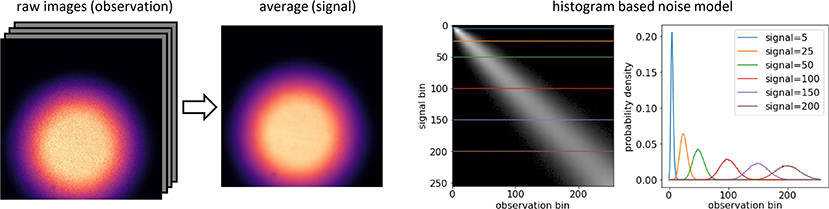

## How to train your own Noise Model - an overview

### If you have access to the microscope that produced the data you want to use during training
As described in detail in the papers we linked above, you must obtain microscopy images that are noisy and cover the relevant range of pixel intensities that are also covered by the data you want to use.

Note that it is NOT important that this data shows any specific structures. You can literally image anything you want. In the original [PN2V paper](https://www.frontiersin.org/journals/computer-science/articles/10.3389/fcomp.2020.00005/full), we have, for example, just imaged the backfocal aperture over and over, making sure that nothing moves and each of the $n$ images we captured is just yet another noisy version of the same image content (see also the image above).

The reason for this is that we can then average those $n$ noisy copies pixel by pixel into a much noise reduced (lets refer to this image as the noise-free ground truth) image.

In order to create the above mentioned mapping between "true" pixel intensities and the observed distribution of noisy measurements, one could simply check for each pixel in the averaged ground truth image, what noisy values we imaged in the $n$ noisy copies.

Since this will lead to situations where rare intensities are not observed frequently enough to make a good mapping, we are using a [Gaussian Mixture Model](https://scikit-learn.org/stable/modules/mixture.html), just as originally proposed in [PPN2V](https://ieeexplore.ieee.org/document/9098612).

Anyway, the details of how we do this are not central to understanding how and why to create und use a Noise Model. If you follow this notebook and later use the created Noise Model to <nobr>Micro$\mathbb{S}$plit</nobr> during training and prediction, the results you will be getting will be of much better quality in terms of [signal-to-noise (SNR)](https://en.wikipedia.org/wiki/Signal-to-noise_ratio#:~:text=Signal%2Dto%2Dnoise%20ratio%20(,power%2C%20often%20expressed%20in%20decibels.).

### You do not have access to the microscope that produced your training data
What we just described requires you to go to the microscope that produced the data you plan to train a <nobr>Micro$\mathbb{S}$plit</nobr> network with. If you do not have access to this microscope, or would like to avoid going through the exercise of creating the appropriate data as described above, you can "bootstrap" yourself to a Noise Model that in many cases will also lead to pretty good denoising performance.

The idea is simple: if you don't have a good surragote for the "true" pixel intensities, you cannot create the mapping we described above. Hence, we need to get our hands on a good estimate of such true intensities for a body of noisy data we have, which we simply achieve by denoising this data with any method of choice that does NOT require a Noise Model itself.
While you can chose any such method, below we will use [Noise2Void (N2V)](https://openaccess.thecvf.com/content_CVPR_2019/papers/Krull_Noise2Void_-_Learning_Denoising_From_Single_Noisy_Images_CVPR_2019_paper.pdf) for this purpose.

# Let's do it, let's train a Noise Model!

**You are new to Jupyter notebooks?** Don't worry, if you take the time to read all our explanations, we will guide you through them and you will understand a lot. Still, you will likely end up less frustrated, if you do not even start with the ambition to interpret the purpose of every line of code.
Let's start with a nice example, the imports to enable the remainder of this notebook. Ignore it (unless you know what you are doing) and just click **⇧*Shift* + ⏎*Enter*** to execute this (and all other) code cells. 

In [1]:
# importing all the things we need further down

import numpy as np
import pooch
import matplotlib.pyplot as plt

from careamics import CAREamist
from careamics.models.lvae.noise_models import GaussianMixtureNoiseModel, create_histogram
from careamics.lvae_training.dataset import DataSplitType
from careamics.config import GaussianMixtureNMConfig
from careamics.config import create_n2v_configuration

# Dataset specific imports...
from microsplit_reproducibility.configs.data.HT_H23B import get_data_configs
from microsplit_reproducibility.datasets.HT_H23B import get_train_val_data
from microsplit_reproducibility.utils.utils import plot_probability_distribution

# **Step 0.1:** Data Preparation

If you want to use your own data, you will have to change this section in an appropriate way.

Without any special modifications, **the following few steps will first choose which subset of the *HT_H23B* dataset to use and then bootstrap a Noise Model from this data**.

The reason to pick a subset of the *HT_H23B* dataset is, that we recorded this data with multiple possible learning tasks in mind. Check the <nobr>Micro$\mathbb{S}$plit</nobr> paper for all the details.

As described above, a Noise Model is specific to an imaging configuration (a microscope) not a specific dataset. Still, since we anyway bootstrap a noise model, we can also use precisely the data we want to also use for network training and we are safe to not mix anything up. 

The coded logic you find below will very likely NOT directly apply to your own data (in case you are about to alter this notebook to operate on your own images). Hence, you might NOT want to be too attached to it. Just look what you might like to keep and delete whatever makes no sense for you. 😉

### Select the two channels you want a Noise Model for, and the exposure time (SNR) of these channel acquisitions you want to use...
To make things more human readable, we use the utility classes we defined above.

Next, we double check that you made a sound choice... no offense! 😉<br>
If you execute the next cell and nothing happens it means all is going well. 

### Download the data you need (given your choices from above)
Depending on your internet connection, this will take a while...

In [2]:
DATA = pooch.create(
    path="./data",
    base_url="https://download.fht.org/jug/msplit/ht_h23b/noise_models/data",
    registry={f"raw_input.zip": None},
)
for fname in DATA.registry:
    DATA.fetch(fname, processor=pooch.Unzip(), progressbar=True)

### Next, we load the image data to be processed

In [3]:
train_data_config, _, _ = get_data_configs()
# we set channels to None because for training of the noise model we only need raw data
train_data_config.channel_list = None

In [4]:
input_data = get_train_val_data(data_config=train_data_config,
                                datadir = DATA.path / f"raw_input.zip.unzip/",
                                datasplit_type=DataSplitType.Train,
                                val_fraction=0.1,
                                test_fraction=0.1,)

Train: 1 Val: 1 Test: 1


In [5]:
train_data = input_data[0]
print(f"We'll use {train_data.shape[0]} images for training")

We'll use 16 images for training


### Show some of the loaded data...

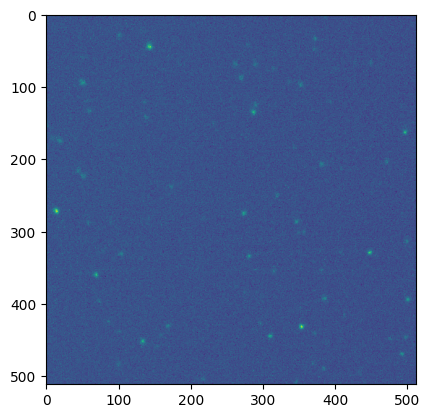

In [6]:
plt.imshow((train_data[0][100:612, 100:612]))
plt.show()

# **Step 0.2:** Using Noise2Void to generate 'clean' data
You do not have access to the microscopye that acquired the data we just downloaded. Hence, as described above, we use a little tick to get the required ground truth data we need to generate a Noise Model -- [Noise2Void (N2V)](https://openaccess.thecvf.com/content_CVPR_2019/papers/Krull_Noise2Void_-_Learning_Denoising_From_Single_Noisy_Images_CVPR_2019_paper.pdf)!

In a nutshell: we train a N2V model, denoise the data we just downloaded, and then create a Noise Model from the noisy raw data and the predictions from [N2V](https://openaccess.thecvf.com/content_CVPR_2019/papers/Krull_Noise2Void_-_Learning_Denoising_From_Single_Noisy_Images_CVPR_2019_paper.pdf).

### Configure N2V
Please note that we have set `num_epochs=10`, so you don't have to wait a long time. If you want a serious Noise Model to be trained, you should change this to a higher number!

In [7]:
config = create_n2v_configuration(
    experiment_name="ht_h23b_noise_models_n2v",
    data_type="array",
    axes="SYX",
    n_channels=1,
    patch_size=(64, 64),
    batch_size=64,
    num_epochs=10, # To make you wait less, we set this to 10. 
                  # If you want a better Noise Model, we suggest 
                  # this value to be higher.
)

print('N2V configuration generated.')
#print(config)

N2V configuration generated.


### Train N2V on the data we prepared
This might take a while, mainly if you changed `num_epochs` above or if you do not have a quick GPU.

In [ ]:
careamist = CAREamist(source=config, work_dir="noise_models")
careamist.train(train_source=train_data, val_minimum_split=5)

### Denoise loaded data with the N2V model we just trained

In [9]:
prediction = careamist.predict(train_data, tile_size=(256, 256))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/localscratch/mamba/envs/splits/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

### Show denoising results obtained with N2V

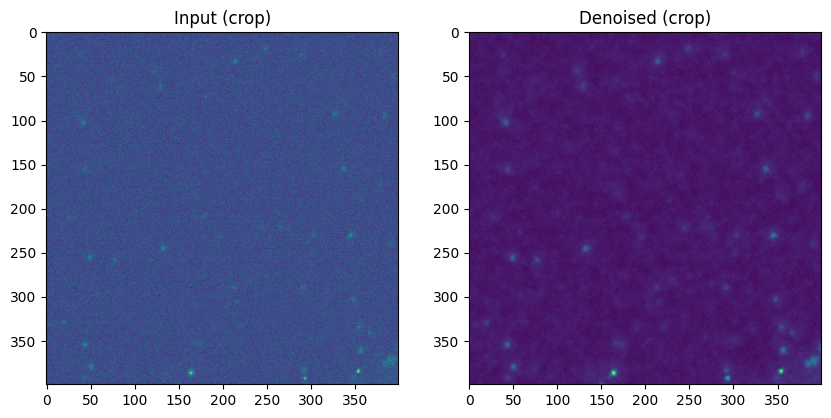

In [10]:
# Maker your choice. If 'False', the entire image will be shown...
do_crop = True

xfrom = yfrom = 0
xto = yto = -1
strcrop=''
if do_crop:
    strcrop=' (crop)'
    yfrom=200
    yto=600
    xfrom=800
    xto=1200

_, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(train_data[0][yfrom:yto,xfrom:xto])
ax[0].set_title("Input"+strcrop)
ax[1].imshow(prediction[0].squeeze()[yfrom:yto,xfrom:xto])
ax[1].set_title("Denoised"+strcrop)

plt.show()

# **Step 0.3:** Train the Noise Model

Finally, here we train a Noise Model using the raw noisy data we downloaded and the denoised images we created with the N2V model we trained. Once done, we will have 'bootstrapped' a Noise Model.

Please note that we need one noise model for each unmixed channel we will later predict with <nobr>Micro$\mathbb{S}$plit</nobr>.


Training noise model
[GaussianMixtureNoiseModel] min_sigma: 200.0
0 3.6121668815612793

The trained parameters (user_trained_noise_model) is saved at location: noise_models


/home/igor.zubarev/projects/microSplit-reproducibility/src/microsplit_reproducibility/utils/utils.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noise_model.min_signal = torch.tensor(
/home/igor.zubarev/projects/microSplit-reproducibility/src/microsplit_reproducibility/utils/utils.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noise_model.max_signal = torch.tensor(
/home/igor.zubarev/projects/microSplit-reproducibility/src/microsplit_reproducibility/utils/utils.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  observations=

{'gmm': {'x': tensor([  83.2600,   97.7800,  112.3000,  126.8200,  141.3400,  155.8600,
           170.3800,  184.9000,  199.4200,  213.9400,  228.4600,  242.9800,
           257.5000,  272.0200,  286.5400,  301.0600,  315.5800,  330.1000,
           344.6200,  359.1400,  373.6600,  388.1800,  402.7000,  417.2200,
           431.7400,  446.2600,  460.7800,  475.3000,  489.8200,  504.3400,
           518.8600,  533.3800,  547.9000,  562.4200,  576.9400,  591.4600,
           605.9800,  620.5000,  635.0200,  649.5400,  664.0600,  678.5800,
           693.1000,  707.6200,  722.1400,  736.6600,  751.1800,  765.7000,
           780.2200,  794.7401,  809.2600,  823.7800,  838.3000,  852.8200,
           867.3400,  881.8600,  896.3800,  910.9000,  925.4200,  939.9400,
           954.4600,  968.9800,  983.5000,  998.0200, 1012.5400, 1027.0601,
          1041.5801, 1056.1001, 1070.6200, 1085.1400, 1099.6600, 1114.1801,
          1128.7000, 1143.2200, 1157.7400, 1172.2600, 1186.7799, 1201.2999,


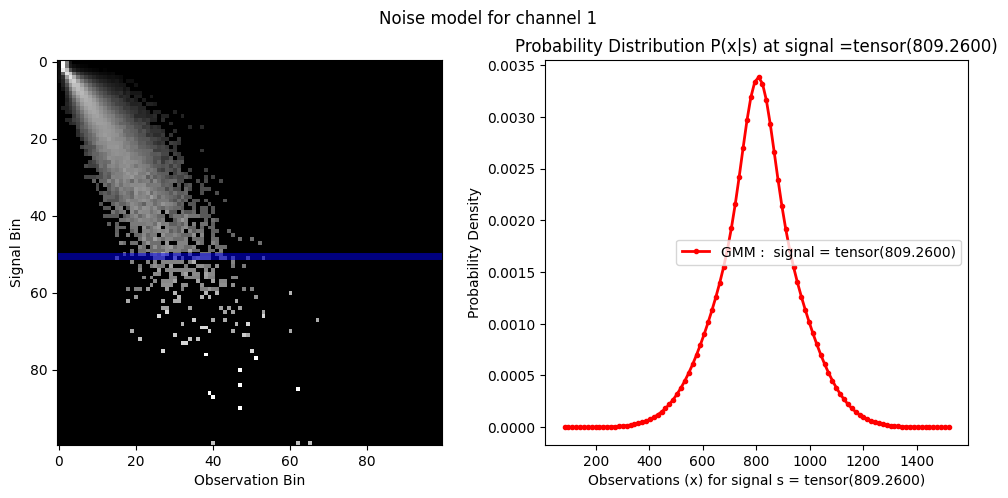

In [11]:
# train Noise Model for current channel
print(f"Training noise model")
prediction = np.concatenate(prediction)
noise_model_config = GaussianMixtureNMConfig(model_type="GaussianMixtureNoiseModel",
                                                min_signal=input_data[0].min(),
                                                max_signal=input_data[0].max(),
                                                n_coeff=4,
                                                n_gaussian=6)
noise_model = GaussianMixtureNoiseModel(noise_model_config)
noise_model.fit(signal=input_data[0], observation=prediction, n_epochs=100)

# save result on disk for later re-use
noise_model.save(path=f"noise_models", name=f"user_trained_noise_model")

# show the result
histogram = create_histogram(bins=100, min_val=input_data[0].min(), max_val=input_data[0].max(), signal=input_data[0], observation=prediction)
plot_probability_distribution(noise_model, signalBinIndex=50, histogram=histogram[0], channel=1)

    

### Once the cell above is ready you are done here! 👍